# Optimal Transport Project
# Numerical methods with entropic regularization




Katya Filimoshina

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

## Sinkhorn algorithm

In [ ]:
def sinkhorn(C, p, q, epsilon, tau, max_iter):
    """
    Sinkhorn's Algorithm for Optimal Transport.

    Parameters:
    - C: Cost matrix (n x n)
    - p: Marginal distribution (n,)
    - q: Marginal distribution (n,)
    - epsilon: Regularization parameter
    - tau: Convergence tolerance
    - max_iter: Maximum number of iterations

    Returns:
    - pi: Approximate transport matrix (n x n)
    - loss: List of transport cost values at each iteration
    - tols: List of convergence tolerance values at each iteration
    """
    K = np.exp(-C / epsilon)
    v = np.ones_like(q)
    loss = []
    tols = []

    for i in range(max_iter):
        u = p / (K @ v)
        v = q / (K.T @ u)

        pi = np.diag(u) @ K @ np.diag(v)
        loss.append(np.sum(pi * C)) # we save the value of the function that we minimize

        tolerance_condition = np.linalg.norm(u * (K @ v) - p, ord=1) + np.linalg.norm(v * (K.T @ u) - q, ord=1)
        tols.append(tolerance_condition)
        if tolerance_condition < tau:
            break
        if i==max_iter-1:
          print('Max_iter is achieved')

    return pi, loss, tols

## Sinkhorn--Knopp algorithm

In [ ]:
import numpy as np

def sinkhorn_knopp(C, p, q, epsilon, tau, max_iter):
    """
    Sinkhorn-Knopp Algorithm for Optimal Transport.

    Parameters:
    - C: Cost matrix (n x n)
    - p: Source distribution (n,)
    - q: Target distribution (n,)
    - epsilon: Regularization parameter
    - tau: Convergence tolerance
    - max_iter: Maximum number of iterations

    Returns:
    - pi: Approximate transport matrix (n x n)
    - loss: List of transport cost values at each iteration
    - tols: List of convergence tolerance values at each iteration
    """
    # Initialize the scaling factors
    pi = np.exp(-C / epsilon)
    loss = []
    tols = []

    for k in range(max_iter):
        # Row scaling
        row_scaling = p / (pi @ np.ones_like(q))
        pi = np.diag(row_scaling) @ pi

        # Column scaling
        col_scaling = q / (pi.T @ np.ones_like(p))
        pi = pi @ np.diag(col_scaling)

        # Compute loss and convergence tolerance
        transport_cost = np.sum(pi * C)
        loss.append(transport_cost)

        tolerance_condition = np.linalg.norm(row_scaling * (pi @ np.ones_like(q)) - p, ord=1) + \
                              np.linalg.norm(col_scaling * (pi.T @ np.ones_like(p)) - q, ord=1)
        tols.append(tolerance_condition)

        if tolerance_condition < tau:
            break
        if k==max_iter-1:
          print('Max_iter is achieved')

    return pi, loss, tols

## Greenkhorn algorithm

In [ ]:
def greenkhorn(C, p, q, epsilon, tau, max_iter):
    """
    Greenkhorn Algorithm for Optimal Transport.

    Parameters:
    - C: Cost matrix (n x n)
    - p: Marginal distribution (n,)
    - q: Marginal distribution (n,)
    - epsilon: Regularization parameter
    - tau: Convergence tolerance
    - max_iter: Maximum number of iterations

    Returns:
    - pi: Approximate transport matrix (n x n)
    - loss: List of transport cost values at each iteration
    - tols: List of convergence tolerance values at each iteration
    """
    # Initialize variables
    K = np.exp(-C / epsilon)
    u = p.copy()
    v = q.copy()
    loss = []
    tols = []

    # Compute the current transport matrix
    pi = np.diag(u) @ K @ np.diag(v)

    for k in range(max_iter):
        # Calculate marginal deviations
        row_marginals = np.sum(pi, axis=1)
        col_marginals = np.sum(pi, axis=0)

        # Find the most violating row and column
        row_violation = np.abs(row_marginals - p)
        col_violation = np.abs(col_marginals - q)
        I = np.argmax(row_violation)
        J = np.argmax(col_violation)

        # Update the most violated row or column
        if row_violation[I] > col_violation[J]:
            u[I] = p[I] / ((K @ v)[I])
        else:
            v[J] = q[J] / ((K.T @ u)[J])

        # Update the transport matrix
        pi = np.diag(u) @ K @ np.diag(v)
        loss.append(np.sum(pi * C))  # Save the current cost value

        # Check for convergence
        tolerance_condition = (
            np.linalg.norm(u * (K @ v) - p, ord=1) +
            np.linalg.norm(v * (K.T @ u) - q, ord=1)
        )
        tols.append(tolerance_condition)
        if tolerance_condition < tau:
            break

        if k==max_iter-1:
          print('Max_iter is achieved')

    return pi, loss, tols


## AGD

inspired by: https://github.com/kkahatapitiya/Numpy-OT/tree/master

In [ ]:
def AGD(M,r,c,eps):
    st = datetime.datetime.now()
    maxIter = 20000
    n = np.size(r)
    max_el = np.max(np.abs(M)) #np.linalg.norm(M, ord=np.inf)
    gamma = eps/(3*np.log(n))

    X = np.zeros((n,n), dtype=np.float64)

    psi_x = np.zeros((1, maxIter), dtype=np.float64) #objective values at points x_k which are accumulated in the model of the function.
    grad_psi_x = np.zeros((2*n, maxIter), dtype=np.float64) #gradient values at x_k which are accumulated in the model of the function
    psi_y = np.zeros((1, maxIter), dtype=np.float64) #objective values at points y_k for which usually the convergence rate is proved
    gap = np.zeros((1, maxIter), dtype=np.float64)
    A = np.zeros((maxIter, 1), dtype=np.float64) #init array of A_k
    L = np.zeros((maxIter, 1), dtype=np.float64) #init array of L_k
    x = np.zeros((2*n, maxIter), dtype=np.float64) #init array of points x_k where the gradient is calculated (lambda)
    y = np.zeros((2*n, maxIter), dtype=np.float64) #init array of points y_k for which usually the convergence rate is proved (eta)
    z = np.zeros((2*n, maxIter), dtype=np.float64) #init array of points z_k. this is the Mirror Descent sequence. (zeta)

    #set initial values for APDAGD
    L[0,0] = 1; #set L_0

    losses = []

    #set starting point for APDAGD
    x[:,0] = np.zeros((2*n, ), dtype=np.float64) #basic choice, set x_0 = 0 since we use Euclidean structure and the set is unbounded

    print('starting APDAGD')

    #main cycle of APDAGD
    for k in range(0,(maxIter-1)):

        print('k=%d'%k) #print current iteration number

        #init for inner cycle
        flag = 1 #flag of the end of the inner cycle
        j = 0 #corresponds to j_k
        while flag > 0:
            print(j); #print current inner iteration number
            L_t = (2**(j-1))*L[k,0] #current trial for L
            a_t = (1  + np.sqrt(1 + 4*L_t*A[k,0]))/(2*L_t) #trial for calculate a_k as solution of quadratic equation explicitly
            A_t = A[k,0] + a_t; #trial of A_k
            tau = a_t / A_t; #trial of \tau_{k}
            x_t = tau*z[:,k] + (1 - tau)*y[:,k]; #trial for x_k

            #calculate trial oracle at xi
            #calculate function \psi(\lambda,\mu) value and gradient at the trial point of x_{k}
            lamb = x_t[:n,]
            mu = x_t[n:2*n,]
            M_new = -M - np.matmul(lamb.reshape(-1,1), np.ones((1,n), dtype=np.float64)) - np.matmul(np.ones((n,1), dtype=np.float64), mu.reshape(-1,1).T)
            X_lamb = np.exp(M_new/gamma)
            sum_X = np.sum(X_lamb)
            X_lamb = X_lamb/sum_X;
            grad_psi_x_t = np.zeros((2*n,), dtype=np.float64) ######
            grad_psi_x_t[:n,] = r - np.sum(X_lamb, axis=1)
            grad_psi_x_t[n:2*n,] = c - np.sum(X_lamb,axis=0).T
            psi_x_t = np.matmul(lamb.T,r) + np.matmul(mu.T,c) + gamma*np.log(sum_X)

            #update model trial
            z_t = z[:,k] - a_t*grad_psi_x_t #trial of z_k
            y_t = tau*z_t + (1 - tau)*y[:,k] #trial of y_k

            #calculate function \psi(\lambda,\mu) value and gradient at the trial point of y_{k}
            lamb = y_t[:n,]
            mu = y_t[n:2*n,]
            M_new = -M - np.matmul(lamb.reshape(-1,1), np.ones((1,n), dtype=np.float64)) - np.matmul(np.ones((n,1), dtype=np.float64), mu.reshape(-1,1).T)
            Z = np.exp(M_new/gamma)
            sum_Z = np.sum(Z)
            psi_y_t = np.matmul(lamb.T,r) + np.matmul(mu.T,c) + gamma*np.log(sum_Z)

            l = psi_x_t + np.matmul(grad_psi_x_t.T,y_t - x_t) + L_t/2*(np.linalg.norm(y_t - x_t, ord=2)**2) #calculate r.h.s. of the stopping criterion in the inner cycle

            ###
            losses.append(np.sum(M * round(tau*X_lamb + (1-tau)*X,r,c)))

            if psi_y_t <= l: #if the stopping criterion is fulfilled
                flag = 0 #end of the inner cycle flag
                x[:,k+1] = x_t #set x_{k+1}
                y[:,k+1] = y_t #set y_{k+1}
                z[:,k+1] = z_t #set y_{k+1}
                psi_y[0,k+1] = psi_y_t #save psi(y_k)
                A[k+1,0] = A_t #set A_{k+1}
                L[k+1,0] = L_t #set L_{k+1}
                X = tau*X_lamb + (1-tau)*X #set primal variable
            j += 1

        #check stopping criterion
        X_hat = round(X,r,c) ##### #Apply rounding procedure from [Altshuler et al, 2017]
        error_constr = np.sum(M*(X_hat-X)) #error in the equality constraints
        print('current error = %f, goal = %f'%(error_constr,eps/(6*max_el)))
        if error_constr < eps/(6*max_el):
            break

    itr = k
    end = datetime.datetime.now()
    print('average time per iteration %f'%((end-st).total_seconds()*1000/itr)) #print current iteration number

    return X_hat, itr, (end-st).total_seconds()*1000, losses



def round(F, r, c):
    rF = np.sum(F, axis=1)
    X = np.diag(np.minimum(np.divide(r, rF), np.ones(r.shape)))
    Fd = np.matmul(X, F)
    cFd = np.sum(Fd, axis=0)
    Y = np.diag(np.minimum(np.divide(c, cFd), np.ones(c.shape)))
    Fdd = np.matmul(Fd, Y)

    err_r = r - np.sum(Fdd, axis=1)
    err_c = c - np.sum(Fdd, axis=0)
    if np.linalg.norm(err_r, ord=1) == 0:
        out = Fdd
    else:
        out = Fdd + np.matmul(err_r.reshape(-1,1), err_c.reshape(1,-1))/np.linalg.norm(err_r, ord=1)
    return out

## Experiments

### 3x3 task

In [ ]:
C = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
p = np.array([0.4, 0.3, 0.3])
q = np.array([0.5, 0.2, 0.3])

print(f"Cost matrix:\n {C}")
print(f"p:\n {p}")
print(f"q:\n {q}")

Cost matrix:
 [[0 1 1]
 [1 0 1]
 [1 1 0]]
p:
 [0.4 0.3 0.3]
q:
 [0.5 0.2 0.3]


#### eps=0.1

In [ ]:
epsilon = 0.1  # Regularization parameter
tau = 1e-6  # Convergence tolerance

pi, loss_s, tols = sinkhorn(C, p, q, epsilon, tau, max_iter=1000)
print(f"Transport Matrix (pi):\n {pi}")
print(f"Final transport cost: {loss_s[-1]}")
print(f"Converged in {len(loss_s)} iterations")

Transport Matrix (pi):
 [[4.00000073e-01 1.66823892e-09 2.12797232e-07]
 [9.88420955e-02 1.99999892e-01 1.15822429e-03]
 [1.15783176e-03 1.06362480e-07 2.98841563e-01]]
Final transport cost: 0.10115847239941189
Converged in 786 iterations


In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(pi).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(pi).sum(axis=0), q))

Correspondence of pi to p: True
Correspondence of pi to q: True


In [ ]:
epsilon = 0.1  # Regularization parameter
tau = 1e-6  # Convergence tolerance

pi, loss_sk, tols = sinkhorn_knopp(C, p, q, epsilon, tau, max_iter=1000)
print(f"Transport Matrix (pi):\n {pi}")
print(f"Final transport cost: {loss_sk[-1]}")
print(f"Converged in {len(loss_sk)} iterations")

Transport Matrix (pi):
 [[4.00000066e-01 1.66823888e-09 2.12796228e-07]
 [9.88420963e-02 1.99999892e-01 1.15821885e-03]
 [1.15783722e-03 1.06362981e-07 2.98841568e-01]]
Final transport cost: 0.10115847323685895
Converged in 788 iterations


In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(pi).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(pi).sum(axis=0), q))

Correspondence of pi to p: True
Correspondence of pi to q: True


In [ ]:
epsilon = 0.1  # Regularization parameter
tau = 1e-6  # Convergence tolerance

pi, loss_gr, tols = greenkhorn(C, p, q, epsilon, tau, max_iter=1000)
print(f"Transport Matrix (pi):\n {pi}")
print(f"Final transport cost: {loss_gr[-1]}")
print(f"Converged in {len(loss_gr)} iterations")

Transport Matrix (pi):
 [[4.00000159e-01 1.66824492e-09 2.12751914e-07]
 [9.88417612e-02 1.99999892e-01 1.15797346e-03]
 [1.15807977e-03 1.06385623e-07 2.98841855e-01]]
Final transport cost: 0.10115813526360722
Converged in 146 iterations


In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(pi).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(pi).sum(axis=0), q))

Correspondence of pi to p: True
Correspondence of pi to q: True


In [ ]:
X_hat, itr, elapsed_time, loss_agd = AGD(C, p, q, eps=0.1)

print(f"Transport Matrix (pi):\n {X_hat}")
print(f"Final transport cost: {loss_agd[-1]}")
print(f"Number of iterations: {itr}")

starting APDAGD
k=0
0
1
2
3
4
5
6
current error = 0.100000, goal = 0.016667
k=1
0
current error = 0.100000, goal = 0.016667
k=2
0
current error = 0.102635, goal = 0.016667
k=3
0
1
2
current error = 0.100000, goal = 0.016667
k=4
0
1
2
current error = 0.100737, goal = 0.016667
k=5
0
current error = 0.100000, goal = 0.016667
k=6
0
current error = 0.100000, goal = 0.016667
k=7
0
1
current error = 0.104082, goal = 0.016667
k=8
0
1
2
3
current error = 0.100000, goal = 0.016667
k=9
0
current error = 0.100000, goal = 0.016667
k=10
0
current error = 0.100000, goal = 0.016667
k=11
0
current error = 0.103360, goal = 0.016667
k=12
0
1
2
3
4
current error = 0.100000, goal = 0.016667
k=13
0
current error = 0.100000, goal = 0.016667
k=14
0
1
current error = 0.100000, goal = 0.016667
k=15
0
1
current error = 0.101556, goal = 0.016667
k=16
0
1
current error = 0.100000, goal = 0.016667
k=17
0
1
2
current error = 0.100737, goal = 0.016667
k=18
0
current error = 0.100406, goal = 0.016667
k=19
0
current er

In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(X_hat).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(X_hat).sum(axis=0), q))

Correspondence of pi to p: True
Correspondence of pi to q: True


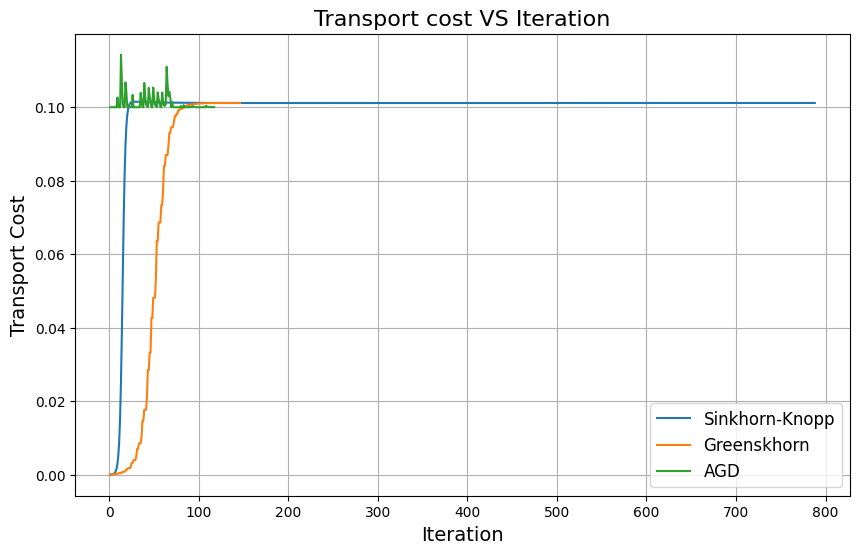

In [ ]:
iterations_s = range(1, len(loss_s) + 1)
iterations_sk = range(1, len(loss_sk) + 1)
iterations_gr = range(1, len(loss_gr) + 1)
iterations_agd = range(1, len(loss_agd) + 1)

plt.figure(figsize=(10, 6))
# plt.plot(iterations_s, loss_s, label="Sinkhorn")
plt.plot(iterations_sk, loss_sk, label="Sinkhorn-Knopp")
plt.plot(iterations_gr, loss_gr, label="Greenskhorn")
plt.plot(iterations_agd, loss_agd, label="AGD")


plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Transport Cost", fontsize=14)
plt.title("Transport cost VS Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)


plt.show()

#### eps=0.0001

In [ ]:
epsilon = 0.0001  # Regularization parameter
tau = 1e-6  # Convergence tolerance

pi, loss_s, tols = sinkhorn(C, p, q, epsilon, tau, max_iter=1000)
print(f"Transport Matrix (pi):\n {pi}")
print(f"Final transport cost: {loss_s[-1]}")
print(f"Converged in {len(loss_s)} iterations")

Max_iter is achieved
Transport Matrix (pi):
 [[0.5 0.  0. ]
 [0.  0.2 0. ]
 [0.  0.  0.3]]
Final transport cost: 0.0
Converged in 1000 iterations


In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(pi).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(pi).sum(axis=0), q))

Correspondence of pi to p: False
Correspondence of pi to q: True


In [ ]:
epsilon = 0.0001  # Regularization parameter
tau = 1e-6  # Convergence tolerance

pi, loss_sk, tols = sinkhorn_knopp(C, p, q, epsilon, tau, max_iter=1000)
print(f"Transport Matrix (pi):\n {pi}")
print(f"Final transport cost: {loss_sk[-1]}")
print(f"Converged in {len(loss_sk)} iterations")

Max_iter is achieved
Transport Matrix (pi):
 [[0.5 0.  0. ]
 [0.  0.2 0. ]
 [0.  0.  0.3]]
Final transport cost: 0.0
Converged in 1000 iterations


In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(pi).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(pi).sum(axis=0), q))

Correspondence of pi to p: False
Correspondence of pi to q: True


In [ ]:
epsilon = 0.0001  # Regularization parameter
tau = 1e-6  # Convergence tolerance

pi, loss_gr, tols = greenkhorn(C, p, q, epsilon, tau, max_iter=1000)
print(f"Transport Matrix (pi):\n {pi}")
print(f"Final transport cost: {loss_gr[-1]}")
print(f"Converged in {len(loss_gr)} iterations")

Max_iter is achieved
Transport Matrix (pi):
 [[0.5 0.  0. ]
 [0.  0.2 0. ]
 [0.  0.  0.3]]
Final transport cost: 0.0
Converged in 1000 iterations


In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(pi).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(pi).sum(axis=0), q))

Correspondence of pi to p: False
Correspondence of pi to q: True


In [ ]:
X_hat, itr, elapsed_time, loss_agd = AGD(C, p, q, eps=0.0001)

print(f"Transport Matrix (pi):\n {X_hat}")
print(f"Final transport cost: {loss_agd[-1]}")
print(f"Number of iterations: {itr}")

starting APDAGD
k=0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
current error = 0.100000, goal = 0.000017
k=1
0
current error = 0.100000, goal = 0.000017
k=2
0
current error = 0.102669, goal = 0.000017
k=3
0
1
2
current error = 0.100000, goal = 0.000017
k=4
0
1
2
current error = 0.100261, goal = 0.000017
k=5
0
current error = 0.100000, goal = 0.000017
k=6
0
current error = 0.100000, goal = 0.000017
k=7
0
1
2
current error = 0.102937, goal = 0.000017
k=8
0
1
current error = 0.100000, goal = 0.000017
k=9
0
1
current error = 0.103564, goal = 0.000017
k=10
0
1
current error = 0.100000, goal = 0.000017
k=11
0
1
2
current error = 0.100953, goal = 0.000017
k=12
0
current error = 0.100778, goal = 0.000017
k=13
0
current error = 0.100000, goal = 0.000017
k=14
0
1
2
current error = 0.103058, goal = 0.000017
k=15
0
1
2
current error = 0.100000, goal = 0.000017
k=16
0
current error = 0.100000, goal = 0.000017
k=17
0
current error = 0.101385, goal = 0.000017
k=18
0
1
2
current error = 0.100000, goal =

<ipython-input-9-c5986aa90255>:71: RuntimeWarning: overflow encountered in exp
  Z = np.exp(M_new/gamma)



k=34
0
current error = 0.100000, goal = 0.000017
k=35
0
current error = 0.100665, goal = 0.000017
k=36
0
1
2
current error = 0.100000, goal = 0.000017
k=37
0
1
2
current error = 0.100349, goal = 0.000017
k=38
0
current error = 0.100524, goal = 0.000017
k=39
0
current error = 0.100000, goal = 0.000017
k=40
0
1
2
3
current error = 0.101126, goal = 0.000017
k=41
0
current error = 0.100269, goal = 0.000017
k=42
0
current error = 0.100132, goal = 0.000017
k=43
0
1
current error = 0.100000, goal = 0.000017
k=44
0
1
2
3
current error = 0.100901, goal = 0.000017
k=45
0
current error = 0.100000, goal = 0.000017
k=46
0
current error = 0.100953, goal = 0.000017
k=47
0
1
2
current error = 0.100000, goal = 0.000017
k=48
0
1
current error = 0.100827, goal = 0.000017
k=49
0
1
current error = 0.100000, goal = 0.000017
k=50
0
1
2
current error = 0.100286, goal = 0.000017
k=51
0
current error = 0.100277, goal = 0.000017
k=52
0
current error = 0.100000, goal = 0.000017
k=53
0
1
2
current error = 0.10106

<ipython-input-9-c5986aa90255>:55: RuntimeWarning: overflow encountered in exp
  X_lamb = np.exp(M_new/gamma)
<ipython-input-9-c5986aa90255>:57: RuntimeWarning: invalid value encountered in divide
  X_lamb = X_lamb/sum_X;


Выходные данные были обрезаны до нескольких последних строк (5000).
current error = 0.000315, goal = 0.000017
k=18751
0
1
current error = 0.000315, goal = 0.000017
k=18752
0
current error = 0.000315, goal = 0.000017
k=18753
0
1
current error = 0.000315, goal = 0.000017
k=18754
0
1
2
current error = 0.000315, goal = 0.000017
k=18755
0
1
2
3
4
current error = 0.000315, goal = 0.000017
k=18756
0
current error = 0.000315, goal = 0.000017
k=18757
0
current error = 0.000314, goal = 0.000017
k=18758
0
1
2
current error = 0.000314, goal = 0.000017
k=18759
0
current error = 0.000314, goal = 0.000017
k=18760
0
1
2
3
current error = 0.000314, goal = 0.000017
k=18761
0
1
current error = 0.000314, goal = 0.000017
k=18762
0
current error = 0.000314, goal = 0.000017
k=18763
0
1
2
current error = 0.000314, goal = 0.000017
k=18764
0
current error = 0.000314, goal = 0.000017
k=18765
0
current error = 0.000314, goal = 0.000017
k=18766
0
1
current error = 0.000314, goal = 0.000017
k=18767
0
1
current erro

In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(X_hat).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(X_hat).sum(axis=0), q))

Correspondence of pi to p: True
Correspondence of pi to q: True


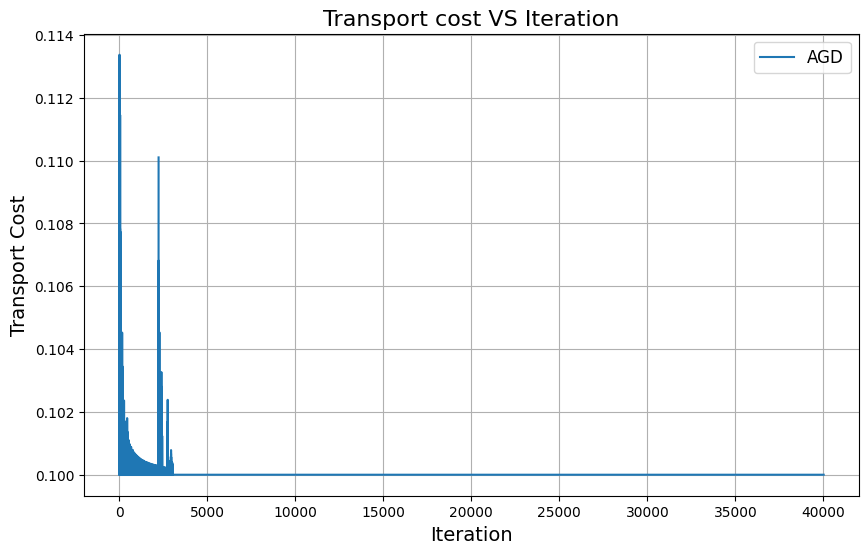

In [ ]:
iterations_s = range(1, len(loss_s) + 1)
iterations_sk = range(1, len(loss_sk) + 1)
iterations_gr = range(1, len(loss_gr) + 1)
iterations_agd = range(1, len(loss_agd) + 1)

plt.figure(figsize=(10, 6))
# plt.plot(iterations_s, loss_s, label="Sinkhorn")
# plt.plot(iterations_sk, loss_sk, label="Sinkhorn-Knopp")
# plt.plot(iterations_gr, loss_gr, label="Greenskhorn")
plt.plot(iterations_agd, loss_agd, label="AGD")


plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Transport Cost", fontsize=14)
plt.title("Transport cost VS Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)


plt.show()

#### eps=0.5

In [ ]:
epsilon = 0.5  # Regularization parameter
tau = 1e-6  # Convergence tolerance

pi, loss_s, tols = sinkhorn(C, p, q, epsilon, tau, max_iter=1000)
print(f"Transport Matrix (pi):\n {pi}")
print(f"Final transport cost: {loss_s[-1]}")
print(f"Converged in {len(loss_s)} iterations")

Transport Matrix (pi):
 [[0.35993932 0.01348355 0.02657745]
 [0.08354499 0.17087298 0.045582  ]
 [0.0565157  0.01564347 0.22784055]]
Final transport cost: 0.24134715672460128
Converged in 16 iterations


In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(pi).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(pi).sum(axis=0), q))

Correspondence of pi to p: True
Correspondence of pi to q: True


In [ ]:
epsilon = 0.5  # Regularization parameter
tau = 1e-6  # Convergence tolerance

pi, loss_sk, tols = sinkhorn_knopp(C, p, q, epsilon, tau, max_iter=1000)
print(f"Transport Matrix (pi):\n {pi}")
print(f"Final transport cost: {loss_sk[-1]}")
print(f"Converged in {len(loss_sk)} iterations")

Transport Matrix (pi):
 [[0.35993919 0.01348354 0.02657741]
 [0.08354504 0.17087298 0.04558197]
 [0.05651578 0.01564348 0.22784061]]
Final transport cost: 0.24134721923914415
Converged in 17 iterations


In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(pi).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(pi).sum(axis=0), q))

Correspondence of pi to p: True
Correspondence of pi to q: True


In [ ]:
epsilon = 0.5  # Regularization parameter
tau = 1e-6  # Convergence tolerance

pi, loss_gr, tols = greenkhorn(C, p, q, epsilon, tau, max_iter=1000)
print(f"Transport Matrix (pi):\n {pi}")
print(f"Final transport cost: {loss_gr[-1]}")
print(f"Converged in {len(loss_gr)} iterations")

Transport Matrix (pi):
 [[0.35993907 0.01348349 0.02657744]
 [0.0835452  0.17087268 0.04558213]
 [0.05651575 0.01564342 0.22784083]]
Final transport cost: 0.24134741608259402
Converged in 58 iterations


In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(pi).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(pi).sum(axis=0), q))

Correspondence of pi to p: True
Correspondence of pi to q: True


In [ ]:
X_hat, itr, elapsed_time, loss_agd = AGD(C, p, q, eps=0.5)

print(f"Transport Matrix (pi):\n {X_hat}")
print(f"Final transport cost: {loss_agd[-1]}")
print(f"Number of iterations: {itr}")

starting APDAGD
k=0
0
1
2
3
current error = 0.099468, goal = 0.083333
k=1
0
current error = 0.100156, goal = 0.083333
k=2
0
1
current error = 0.099200, goal = 0.083333
k=3
0
1
2
current error = 0.105484, goal = 0.083333
k=4
0
1
current error = 0.098639, goal = 0.083333
k=5
0
current error = 0.102589, goal = 0.083333
k=6
0
1
2
current error = 0.097247, goal = 0.083333
k=7
0
1
current error = 0.098550, goal = 0.083333
k=8
0
1
current error = 0.094504, goal = 0.083333
k=9
0
1
current error = 0.092876, goal = 0.083333
k=10
0
current error = 0.085538, goal = 0.083333
k=11
0
1
2
3
current error = 0.082236, goal = 0.083333
average time per iteration 3.070636
Transport Matrix (pi):
 [[3.99795590e-01 5.75413775e-05 1.46868451e-04]
 [9.64077774e-02 1.99841909e-01 3.75031374e-03]
 [3.79663241e-03 1.00549783e-04 2.96102818e-01]]
Final transport cost: 0.10425968317895995
Number of iterations: 11


In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(X_hat).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(X_hat).sum(axis=0), q))

Correspondence of pi to p: True
Correspondence of pi to q: True


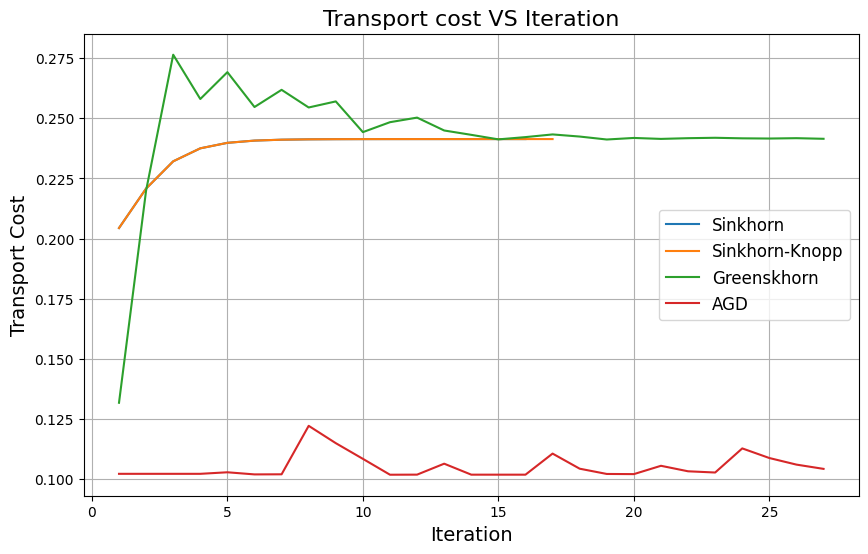

In [ ]:
iterations_s = range(1, len(loss_s) + 1)
iterations_sk = range(1, len(loss_sk) + 1)
# iterations_gr = range(1, len(loss_gr) + 1)
iterations_agd = range(1, len(loss_agd) + 1)

plt.figure(figsize=(10, 6))
plt.plot(iterations_s, loss_s, label="Sinkhorn")
plt.plot(iterations_sk, loss_sk, label="Sinkhorn-Knopp")
plt.plot(iterations_agd, loss_gr[:len(loss_agd)], label="Greenskhorn")
plt.plot(iterations_agd, loss_agd, label="AGD")


plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Transport Cost", fontsize=14)
plt.title("Transport cost VS Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)


plt.show()

### 100x100 task

In [ ]:
# random symmetric matrix with 0 on the diagonal
n = 100
np.random.seed(42)
A = np.random.rand(n, n)
C = (A + A.T) / 2
np.fill_diagonal(C, 0)

# generate p and q
p = np.random.rand(n)
q = np.random.rand(n)
p = p / p.sum()
q = q / q.sum()

print("Shape of C:", C.shape)
print("Shape of p:", p.shape, "Sum of p:", np.sum(p))
print("Shape of q:", q.shape, "Sum of q:", np.sum(q))

Shape of C: (100, 100)
Shape of p: (100,) Sum of p: 1.0
Shape of q: (100,) Sum of q: 0.9999999999999999


#### eps=0.1

In [ ]:
epsilon = 0.1  # Regularization parameter
tau = 1e-6  # Convergence tolerance

pi, loss_s, tols = sinkhorn(C, p, q, epsilon, tau, max_iter=1000)
print(f"Transport Matrix (pi):\n {pi}")
print(f"Final transport cost: {loss_s[-1]}")
print(f"Converged in {len(loss_s)} iterations")

Transport Matrix (pi):
 [[1.57494747e-03 8.96655337e-06 2.88345720e-06 ... 3.27240213e-06
  1.07339226e-05 3.48011455e-04]
 [1.22310262e-05 1.28297251e-03 3.99156795e-04 ... 5.57913654e-06
  2.83533188e-06 2.21565652e-06]
 [7.92466010e-07 8.04217103e-05 1.34569112e-03 ... 6.32908222e-06
  6.90192598e-06 1.00696617e-04]
 ...
 [6.78238894e-06 8.47706782e-06 4.77298014e-05 ... 2.49143464e-03
  4.69205618e-06 1.01842410e-07]
 [2.67694218e-05 5.18378614e-06 6.26301850e-05 ... 5.64582887e-06
  6.02877013e-04 7.28658250e-05]
 [4.44377633e-04 2.07407153e-06 4.67849745e-04 ... 6.27438692e-08
  3.73080033e-05 3.63927209e-04]]
Final transport cost: 0.17187093765188727
Converged in 9 iterations


In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(pi).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(pi).sum(axis=0), q))

Correspondence of pi to p: True
Correspondence of pi to q: True


In [ ]:
epsilon = 0.1  # Regularization parameter
tau = 1e-6  # Convergence tolerance

pi, loss_sk, tols = sinkhorn_knopp(C, p, q, epsilon, tau, max_iter=1000)
print(f"Transport Matrix (pi):\n {pi}")
print(f"Final transport cost: {loss_sk[-1]}")
print(f"Converged in {len(loss_sk)} iterations")

Transport Matrix (pi):
 [[1.57494764e-03 8.96655705e-06 2.88345674e-06 ... 3.27240295e-06
  1.07339214e-05 3.48011524e-04]
 [1.22310201e-05 1.28297226e-03 3.99156491e-04 ... 5.57913457e-06
  2.83532986e-06 2.21565562e-06]
 [7.92466342e-07 8.04217684e-05 1.34569133e-03 ... 6.32908580e-06
  6.90192740e-06 1.00696668e-04]
 ...
 [6.78238591e-06 8.47706660e-06 4.77297676e-05 ... 2.49143389e-03
  4.69205308e-06 1.01842374e-07]
 [2.67694297e-05 5.18378925e-06 6.26301872e-05 ... 5.64583138e-06
  6.02877064e-04 7.28658534e-05]
 [4.44377615e-04 2.07407207e-06 4.67849603e-04 ... 6.27438759e-08
  3.73079938e-05 3.63927229e-04]]
Final transport cost: 0.1718709407095567
Converged in 10 iterations


In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(pi).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(pi).sum(axis=0), q))

Correspondence of pi to p: True
Correspondence of pi to q: True


In [ ]:
epsilon = 0.1  # Regularization parameter
tau = 1e-6  # Convergence tolerance

pi, loss_gr, tols = greenkhorn(C, p, q, epsilon, tau, max_iter=1000)
print(f"Transport Matrix (pi):\n {pi}")
print(f"Final transport cost: {loss_gr[-1]}")
print(f"Converged in {len(loss_gr)} iterations")

Max_iter is achieved
Transport Matrix (pi):
 [[1.57495509e-03 8.96662764e-06 2.88341256e-06 ... 3.27241976e-06
  1.07336925e-05 3.48013106e-04]
 [1.22310463e-05 1.28297904e-03 3.99149344e-04 ... 5.57914883e-06
  2.83526207e-06 2.21565997e-06]
 [7.92478916e-07 8.04232974e-05 1.34568570e-03 ... 6.32918881e-06
  6.90185709e-06 1.00698248e-04]
 ...
 [6.78238661e-06 8.47709414e-06 4.77288154e-05 ... 2.49143516e-03
  4.69193132e-06 1.01842366e-07]
 [2.67700444e-05 5.18392459e-06 6.26303695e-05 ... 5.64596333e-06
  6.02875200e-04 7.28675134e-05]
 [4.44380193e-04 2.07409063e-06 4.67842936e-04 ... 6.27442655e-08
  3.73072382e-05 3.63929274e-04]]
Final transport cost: 0.1718708723600664
Converged in 1000 iterations


In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(pi).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(pi).sum(axis=0), q))

Correspondence of pi to p: False
Correspondence of pi to q: False


In [ ]:
X_hat, itr, elapsed_time, loss_agd = AGD(C, p, q, eps=0.1)

print(f"Transport Matrix (pi):\n {X_hat}")
print(f"Final transport cost: {loss_agd[-1]}")
print(f"Number of iterations: {itr}")

starting APDAGD
k=0
0
1
2
current error = 0.210997, goal = 0.016913
k=1
0
current error = 0.174773, goal = 0.016913
k=2
0
1
2
current error = 0.180043, goal = 0.016913
k=3
0
1
2
current error = 0.168381, goal = 0.016913
k=4
0
current error = 0.169311, goal = 0.016913
k=5
0
1
2
current error = 0.164950, goal = 0.016913
k=6
0
current error = 0.162809, goal = 0.016913
k=7
0
1
2
current error = 0.159085, goal = 0.016913
k=8
0
1
current error = 0.153729, goal = 0.016913
k=9
0
current error = 0.147178, goal = 0.016913
k=10
0
1
2
current error = 0.142097, goal = 0.016913
k=11
0
1
current error = 0.135704, goal = 0.016913
k=12
0
1
current error = 0.128729, goal = 0.016913
k=13
0
current error = 0.117573, goal = 0.016913
k=14
0
1
2
3
current error = 0.112523, goal = 0.016913
k=15
0
current error = 0.105334, goal = 0.016913
k=16
0
1
current error = 0.097937, goal = 0.016913
k=17
0
1
current error = 0.090759, goal = 0.016913
k=18
0
1
current error = 0.084136, goal = 0.016913
k=19
0
current error 

In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(X_hat).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(X_hat).sum(axis=0), q))

Correspondence of pi to p: True
Correspondence of pi to q: True


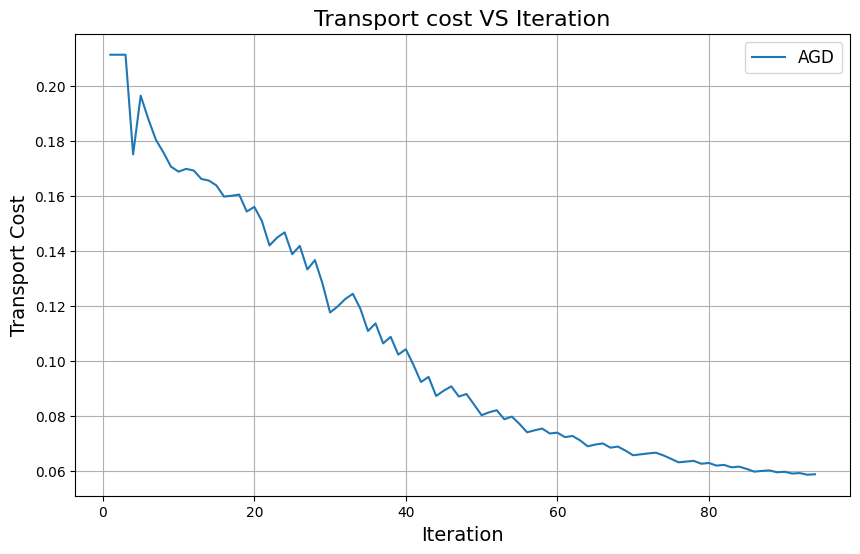

In [ ]:
iterations_s = range(1, len(loss_s) + 1)
iterations_sk = range(1, len(loss_sk) + 1)
iterations_gr = range(1, len(loss_gr) + 1)
iterations_agd = range(1, len(loss_agd) + 1)

plt.figure(figsize=(10, 6))
# plt.plot(iterations_s, loss_s, label="Sinkhorn")
# plt.plot(iterations_sk, loss_sk, label="Sinkhorn-Knopp")
# plt.plot(iterations_gr, loss_gr, label="Greenskhorn")
plt.plot(iterations_agd, loss_agd, label="AGD")


plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Transport Cost", fontsize=14)
plt.title("Transport cost VS Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)


plt.show()

#### eps=0.0001

In [ ]:
epsilon = 0.0001  # Regularization parameter
tau = 1e-6  # Convergence tolerance

pi, loss_s, tols = sinkhorn(C, p, q, epsilon, tau, max_iter=1000)
print(f"Transport Matrix (pi):\n {pi}")
print(f"Final transport cost: {loss_s[-1]}")
print(f"Converged in {len(loss_s)} iterations")

<ipython-input-17-8d451a8956d8>:25: RuntimeWarning: overflow encountered in divide
  v = q / (K.T @ u)
<ipython-input-17-8d451a8956d8>:27: RuntimeWarning: invalid value encountered in matmul
  pi = np.diag(u) @ K @ np.diag(v)
<ipython-input-17-8d451a8956d8>:28: RuntimeWarning: invalid value encountered in multiply
  loss.append(np.sum(pi * C)) # we save the value of the function that we minimize
<ipython-input-17-8d451a8956d8>:30: RuntimeWarning: invalid value encountered in matmul
  tolerance_condition = np.linalg.norm(u * (K @ v) - p, ord=1) + np.linalg.norm(v * (K.T @ u) - q, ord=1)
<ipython-input-17-8d451a8956d8>:24: RuntimeWarning: invalid value encountered in matmul
  u = p / (K @ v)


Max_iter is achieved
Transport Matrix (pi):
 [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Final transport cost: nan
Converged in 1000 iterations


In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(pi).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(pi).sum(axis=0), q))

Correspondence of pi to p: False
Correspondence of pi to q: False


In [ ]:
epsilon = 0.0001  # Regularization parameter
tau = 1e-6  # Convergence tolerance

pi, loss_sk, tols = sinkhorn_knopp(C, p, q, epsilon, tau, max_iter=1000)
print(f"Transport Matrix (pi):\n {pi}")
print(f"Final transport cost: {loss_sk[-1]}")
print(f"Converged in {len(loss_sk)} iterations")

Max_iter is achieved
Transport Matrix (pi):
 [[8.67797580e-003 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 5.01509752e-003 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 2.05691039e-002 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 ...
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 2.76710929e-003
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  4.22235179e-003 0.00000000e+000]
 [8.85695208e-234 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 4.90838832e-003]]
Final transport cost: 0.008003626727512972
Converged in 1000 iterations


In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(pi).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(pi).sum(axis=0), q))

Correspondence of pi to p: False
Correspondence of pi to q: True


In [ ]:
epsilon = 0.0001  # Regularization parameter
tau = 1e-6  # Convergence tolerance

pi, loss_gr, tols = greenkhorn(C, p, q, epsilon, tau, max_iter=1000)
print(f"Transport Matrix (pi):\n {pi}")
print(f"Final transport cost: {loss_gr[-1]}")
print(f"Converged in {len(loss_gr)} iterations")

<ipython-input-8-74c6d6fe7403>:43: RuntimeWarning: overflow encountered in scalar divide
  v[J] = q[J] / ((K.T @ u)[J])
<ipython-input-8-74c6d6fe7403>:46: RuntimeWarning: invalid value encountered in matmul
  pi = np.diag(u) @ K @ np.diag(v)
<ipython-input-8-74c6d6fe7403>:47: RuntimeWarning: invalid value encountered in multiply
  loss.append(np.sum(pi * C))  # Save the current cost value
<ipython-input-8-74c6d6fe7403>:51: RuntimeWarning: invalid value encountered in matmul
  np.linalg.norm(u * (K @ v) - p, ord=1) +


Max_iter is achieved
Transport Matrix (pi):
 [[1.50445697e-004 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 1.23541050e-289]
 [0.00000000e+000 8.51575478e-005 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 7.16080104e-005 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 ...
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 2.27702696e-004
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  2.01278718e-005 0.00000000e+000]
 [2.30761536e-289 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 1.63104786e-005]]
Final transport cost: nan
Converged in 1000 iterations


In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(pi).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(pi).sum(axis=0), q))

Correspondence of pi to p: False
Correspondence of pi to q: False


In [ ]:
X_hat, itr, elapsed_time, loss_agd = AGD(C, p, q, eps=0.0001)

print(f"Transport Matrix (pi):\n {X_hat}")
print(f"Final transport cost: {loss_agd[-1]}")
print(f"Number of iterations: {itr}")

starting APDAGD
k=0
0
1
2
3
4
5
6
7
8
9
10
11
12
current error = 0.211900, goal = 0.000017
k=1
0
current error = 0.177805, goal = 0.000017
k=2
0
1
2
current error = 0.187441, goal = 0.000017
k=3
0
1
2
current error = 0.176354, goal = 0.000017
k=4
0
current error = 0.178567, goal = 0.000017
k=5
0
1
2
current error = 0.176130, goal = 0.000017
k=6
0
current error = 0.177554, goal = 0.000017
k=7
0
1
2
current error = 0.175929, goal = 0.000017
k=8
0
current error = 0.176896, goal = 0.000017
k=9
0
1
2
current error = 0.175994, goal = 0.000017
k=10
0
current error = 0.176197, goal = 0.000017
k=11
0
1
2
current error = 0.175980, goal = 0.000017
k=12
0
current error = 0.175969, goal = 0.000017
k=13
0
1
2
current error = 0.175973, goal = 0.000017
k=14
0
current error = 0.176030, goal = 0.000017
k=15
0
1
2
current error = 0.175953, goal = 0.000017
k=16
0
current error = 0.176149, goal = 0.000017
k=17
0
1
2
current error = 0.175864, goal = 0.000017
k=18
0
current error = 0.176121, goal = 0.000017


<ipython-input-9-c5986aa90255>:71: RuntimeWarning: overflow encountered in exp
  Z = np.exp(M_new/gamma)


current error = 0.175811, goal = 0.000017
k=28
0
current error = 0.176251, goal = 0.000017
k=29
0
1
2
current error = 0.176151, goal = 0.000017
k=30
0
1
current error = 0.175811, goal = 0.000017
k=31
0
current error = 0.176083, goal = 0.000017
k=32
0
1
2
current error = 0.175811, goal = 0.000017
k=33
0
current error = 0.175998, goal = 0.000017
k=34
0
1
2
current error = 0.175911, goal = 0.000017
k=35
0
current error = 0.175811, goal = 0.000017
k=36
0
1
current error = 0.176158, goal = 0.000017
k=37
0
1
2
3
current error = 0.175874, goal = 0.000017
k=38
0
current error = 0.176117, goal = 0.000017
k=39
0
1
current error = 0.175811, goal = 0.000017
k=40
0
current error = 0.175811, goal = 0.000017
k=41
0
current error = 0.176034, goal = 0.000017
k=42
0
1
2
3
4
5
6
current error = 0.175811, goal = 0.000017
k=43
0
current error = 0.175811, goal = 0.000017
k=44
0
current error = 0.175811, goal = 0.000017
k=45
0
current error = 0.175811, goal = 0.000017
k=46
0
current error = 0.175870, goal = 

<ipython-input-9-c5986aa90255>:55: RuntimeWarning: overflow encountered in exp
  X_lamb = np.exp(M_new/gamma)
<ipython-input-9-c5986aa90255>:57: RuntimeWarning: invalid value encountered in divide
  X_lamb = X_lamb/sum_X;
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Выходные данные были обрезаны до нескольких последних строк (5000).
0
1
current error = 0.087241, goal = 0.000017
k=18754
0
1
current error = 0.087241, goal = 0.000017
k=18755
0
1
current error = 0.087241, goal = 0.000017
k=18756
0
1
current error = 0.087241, goal = 0.000017
k=18757
0
1
current error = 0.087241, goal = 0.000017
k=18758
0
1
current error = 0.087241, goal = 0.000017
k=18759
0
1
current error = 0.087241, goal = 0.000017
k=18760
0
1
current error = 0.087241, goal = 0.000017
k=18761
0
1
current error = 0.087241, goal = 0.000017
k=18762
0
1
current error = 0.087241, goal = 0.000017
k=18763
0
1
current error = 0.087241, goal = 0.000017
k=18764
0
1
current error = 0.087241, goal = 0.000017
k=18765
0
1
current error = 0.087241, goal = 0.000017
k=18766
0
1
current error = 0.087241, goal = 0.000017
k=18767
0
1
current error = 0.087241, goal = 0.000017
k=18768
0
1
current error = 0.087241, goal = 0.000017
k=18769
0
1
current error = 0.087241, goal = 0.000017
k=18770
0
1
current er

In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(X_hat).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(X_hat).sum(axis=0), q))

Correspondence of pi to p: True
Correspondence of pi to q: True


#### eps=0.5

In [ ]:
epsilon = 0.5  # Regularization parameter
tau = 1e-6  # Convergence tolerance

pi, loss_s, tols = sinkhorn(C, p, q, epsilon, tau, max_iter=1000)
print(f"Transport Matrix (pi):\n {pi}")
print(f"Final transport cost: {loss_s[-1]}")
print(f"Converged in {len(loss_s)} iterations")

Transport Matrix (pi):
 [[3.19781301e-04 8.02964875e-05 9.29819946e-05 ... 7.78086808e-05
  3.41083879e-05 7.22830169e-05]
 [1.11497676e-04 1.99612758e-04 2.29624513e-04 ... 7.97519853e-05
  2.40770718e-05 2.42209646e-05]
 [4.04591796e-05 7.19560301e-05 1.83664968e-04 ... 5.13031415e-05
  1.80436608e-05 3.25942980e-05]
 ...
 [1.77059528e-04 1.30696358e-04 2.68297727e-04 ... 4.82822534e-04
  4.75800676e-05 2.33747088e-05]
 [9.57792928e-05 4.86905671e-05 1.16443935e-04 ... 5.87143474e-05
  5.16534370e-05 3.57739024e-05]
 [1.31831668e-04 3.18130746e-05 1.36617676e-04 ... 1.87343417e-05
  2.32348226e-05 3.87248663e-05]]
Final transport cost: 0.40359035501509166
Converged in 3 iterations


In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(pi).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(pi).sum(axis=0), q))

Correspondence of pi to p: True
Correspondence of pi to q: True


In [ ]:
epsilon = 0.5  # Regularization parameter
tau = 1e-6  # Convergence tolerance

pi, loss_sk, tols = sinkhorn_knopp(C, p, q, epsilon, tau, max_iter=1000)
print(f"Transport Matrix (pi):\n {pi}")
print(f"Final transport cost: {loss_sk[-1]}")
print(f"Converged in {len(loss_sk)} iterations")

Transport Matrix (pi):
 [[3.19781394e-04 8.02965173e-05 9.29820331e-05 ... 7.78087146e-05
  3.41084001e-05 7.22830425e-05]
 [1.11497624e-04 1.99612681e-04 2.29624434e-04 ... 7.97519594e-05
  2.40770621e-05 2.42209548e-05]
 [4.04591505e-05 7.19559841e-05 1.83664858e-04 ... 5.13031120e-05
  1.80436490e-05 3.25942767e-05]
 ...
 [1.77059330e-04 1.30696222e-04 2.68297461e-04 ... 4.82822064e-04
  4.75800176e-05 2.33746842e-05]
 [9.57792550e-05 4.86905519e-05 1.16443903e-04 ... 5.87143328e-05
  5.16534200e-05 3.57738906e-05]
 [1.31831655e-04 3.18130740e-05 1.36617679e-04 ... 1.87343425e-05
  2.32348218e-05 3.87248648e-05]]
Final transport cost: 0.4035903622828641
Converged in 4 iterations


In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(pi).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(pi).sum(axis=0), q))

Correspondence of pi to p: True
Correspondence of pi to q: True


In [ ]:
epsilon = 0.5  # Regularization parameter
tau = 1e-6  # Convergence tolerance

pi, loss_gr, tols = greenkhorn(C, p, q, epsilon, tau, max_iter=1000)
print(f"Transport Matrix (pi):\n {pi}")
print(f"Final transport cost: {loss_gr[-1]}")
print(f"Converged in {len(loss_gr)} iterations")

Transport Matrix (pi):
 [[3.19781588e-04 8.02965760e-05 9.29820916e-05 ... 7.78087888e-05
  3.41084477e-05 7.22831321e-05]
 [1.11497599e-04 1.99612662e-04 2.29624388e-04 ... 7.97519694e-05
  2.40770758e-05 2.42209648e-05]
 [4.04590251e-05 7.19557699e-05 1.83664293e-04 ... 5.13029707e-05
  1.80436073e-05 3.25941962e-05]
 ...
 [1.77059280e-04 1.30696201e-04 2.68297391e-04 ... 4.82822095e-04
  4.75800417e-05 2.33746923e-05]
 [9.57789578e-05 4.86904067e-05 1.16443545e-04 ... 5.87141708e-05
  5.16533004e-05 3.57738021e-05]
 [1.31831376e-04 3.18130106e-05 1.36617393e-04 ... 1.87343093e-05
  2.32347910e-05 3.87248073e-05]]
Final transport cost: 0.40359028875137626
Converged in 610 iterations


In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(pi).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(pi).sum(axis=0), q))

Correspondence of pi to p: True
Correspondence of pi to q: True


In [ ]:
X_hat, itr, elapsed_time, loss_agd = AGD(C, p, q, eps=0.5)

print(f"Transport Matrix (pi):\n {X_hat}")
print(f"Final transport cost: {loss_agd[-1]}")
print(f"Number of iterations: {itr}")

starting APDAGD
k=0
0
current error = 0.204652, goal = 0.084564
k=1
0
current error = 0.151375, goal = 0.084564
k=2
0
1
2
current error = 0.133404, goal = 0.084564
k=3
0
1
2
current error = 0.119322, goal = 0.084564
k=4
0
current error = 0.104645, goal = 0.084564
k=5
0
1
current error = 0.089381, goal = 0.084564
k=6
0
1
2
current error = 0.079327, goal = 0.084564
average time per iteration 8.211833
Transport Matrix (pi):
 [[5.38519902e-03 4.64039820e-07 3.06757847e-06 ... 1.71793963e-07
  1.09663972e-07 3.97857738e-04]
 [1.32269874e-06 4.06568621e-03 8.46330831e-05 ... 2.66139770e-07
  1.26911360e-07 1.41727612e-06]
 [5.50678473e-08 4.15801456e-06 3.20816690e-03 ... 1.36933644e-08
  2.62549169e-08 2.90747472e-05]
 ...
 [8.29632170e-06 4.48796777e-06 3.00588653e-05 ... 7.27099533e-03
  7.97816498e-07 8.94247627e-06]
 [6.13470173e-07 2.64483337e-07 2.64077778e-06 ... 9.94010636e-08
  3.21016528e-03 9.77330022e-06]
 [5.69515292e-04 7.46507896e-08 3.82330874e-04 ... 2.77733357e-08
  3.0997

In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(X_hat).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(X_hat).sum(axis=0), q))

Correspondence of pi to p: True
Correspondence of pi to q: True


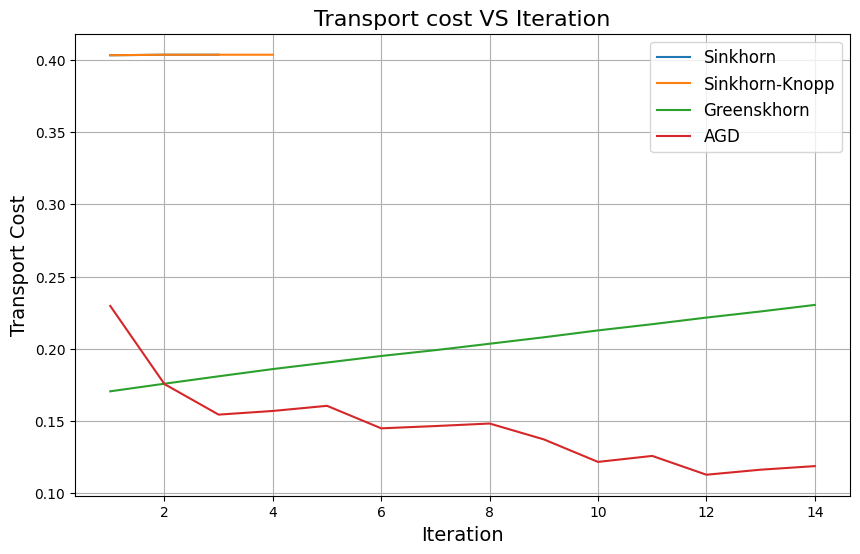

In [ ]:
iterations_s = range(1, len(loss_s) + 1)
iterations_sk = range(1, len(loss_sk) + 1)
# iterations_gr = range(1, len(loss_gr) + 1)
iterations_agd = range(1, len(loss_agd) + 1)

plt.figure(figsize=(10, 6))
plt.plot(iterations_s, loss_s, label="Sinkhorn")
plt.plot(iterations_sk, loss_sk, label="Sinkhorn-Knopp")
plt.plot(iterations_agd, loss_gr[:len(loss_agd)], label="Greenskhorn")
plt.plot(iterations_agd, loss_agd, label="AGD")


plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Transport Cost", fontsize=14)
plt.title("Transport cost VS Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)


plt.show()

### 10000x10000 task

In [ ]:
# random symmetric matrix with 0 on the diagonal
n = 10000
np.random.seed(42)
A = np.random.rand(n, n)
C = (A + A.T) / 2
np.fill_diagonal(C, 0)

# generate p and q
p = np.random.rand(n)
q = np.random.rand(n)
p = p / p.sum()
q = q / q.sum()

print("Shape of C:", C.shape)
print("Shape of p:", p.shape, "Sum of p:", np.sum(p))
print("Shape of q:", q.shape, "Sum of q:", np.sum(q))

Shape of C: (10000, 10000)
Shape of p: (10000,) Sum of p: 1.0
Shape of q: (10000,) Sum of q: 1.0


#### eps=0.1

In [ ]:
epsilon = 0.1  # Regularization parameter
tau = 1e-6  # Convergence tolerance

pi, loss_s, tols = sinkhorn(C, p, q, epsilon, tau, max_iter=1000)
print(f"Transport Matrix (pi):\n {pi}")
print(f"Final transport cost: {loss_s[-1]}")
print(f"Converged in {len(loss_s)} iterations")

Transport Matrix (pi):
 [[1.05030954e-07 1.13011698e-11 2.68083992e-11 ... 1.10078039e-09
  2.82950427e-10 9.85805909e-10]
 [2.17214178e-10 1.31915397e-08 1.02598764e-08 ... 3.39939821e-08
  7.54519575e-09 1.01674458e-08]
 [1.76926978e-10 3.52290178e-09 1.00948370e-07 ... 5.34546086e-08
  1.52530808e-08 4.50454270e-09]
 ...
 [1.83815262e-10 2.95337199e-10 1.35251739e-09 ... 3.70415803e-08
  6.12198003e-11 2.13558473e-11]
 [6.32324668e-11 8.77274510e-11 5.16492671e-10 ... 8.19295929e-11
  1.21849347e-07 1.41227079e-11]
 [4.38800324e-09 2.35462970e-09 3.03810691e-09 ... 5.69261021e-10
  2.81296111e-10 1.42827218e-08]]
Final transport cost: 0.1928657204237296
Converged in 3 iterations


In [ ]:
print('Correspondence of pi to p:', np.allclose(np.array(pi).sum(axis=1), p))
print('Correspondence of pi to q:', np.allclose(np.array(pi).sum(axis=0), q))

Correspondence of pi to p: True
Correspondence of pi to q: True


## Application of OT to style transfer problem

In this example, we apply POT library to the task of color transfer.

In [ ]:
import numpy as np
import cv2
from scipy.spatial.distance import cdist
import ot
from time import time
from PIL import Image

In [ ]:
!pip install --upgrade pip
!pip install setuptools
!pip install --upgrade setuptools --ignore-installed

!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install cython
!pip install POT
!pip install colour-science
!pip install colour-science[optional]
!pip install colour-science[plotting]
!pip install colour-science[tests]
!pip install colour-science[docs]
!pip install colour-science[development]

!pip install pymanopt autograd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 56.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 52.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.8 MB/s eta 0:00:00
  Created wheel for biblib-simple: filename=biblib_simple-0.1.2-py3-none-any.whl size=20157 sha256=3c6e8c0d153099f11d514a41fdc7a07dc20ad06c4dc524ca0e48fe79d41bfd5e
  Stored in directory: /root/.cache/pip/wheels/1b/f5/6e/814da2e7cae4046ebe1dfb8c6365f5c53df4947c5903569dd3
  Created wheel for restructuredtext-lint: filename=restructuredtext_lint-1.4.0-py3-none-any.whl size=13772 sha256=c071cc4be3324fbed1ed685d10ce9ffb628c1475f465cbb66c4ad78f497af9

In [ ]:
def matrixToImage(X, shape):
    """Transform a flatten image to a regular image
    """
    return X.reshape(shape)

def imageToMatrix(im):
    """Transform an image into a "1 column" matrix : one pixel per line
    """
    return im.reshape((im.shape[0] * im.shape[1], im.shape[2]))

def minmax(im):
    """Cut extra values of an image. Values lower than 0 become 0,
    values greater than one become 1
    """
    return np.clip(im, 0, 1)

In [ ]:
def plot_original_images(I1, I2):
    """Plot the images I1 and I2 side by side
    """
    plt.figure(1, figsize=(12.8, 6))

    plt.subplot(1, 2, 1)  # 1 row, 2 columns
    plt.imshow(I1)
    plt.axis('off')
    plt.title('Image 1')

    plt.subplot(1, 2, 2)
    plt.imshow(I2)
    plt.axis('off')
    plt.title('Image 2')

    plt.tight_layout()

    plt.savefig("preview.jpg", bbox_inches='tight')



def plot_optimal_transport_results(I1, I2, Image_sinkhorn):
    """Plot the new images obtain by applying optimal transport and
    changing the colors
    """
    plt.figure(4, figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(I1)
    plt.axis('off')
    plt.title('Image 1')

    plt.subplot(1, 3, 2)
    plt.imshow(I2)
    plt.axis('off')
    plt.title('Image 2')

    plt.subplot(1, 3, 3)
    plt.imshow(Image_sinkhorn)
    plt.axis('off')
    plt.title('SinkhornTransport')

    plt.savefig("optimal_transport.jpg", bbox_inches='tight')

    plt.show()

In [ ]:
def apply_optimal_transport(X1, Xs, Xt, row, col):
    """Apply optimal transport on Xs and Xt.
    Apply a linear modification on X1 based on the closest point on
    Xs and its linked point's color on Xt.

    Args:
        X1 (array): Source image
        Xs (array): source pixels
        Xt (array): target pixels
        row (int): vertical dimension of source image
        col (int): horizontal dimension of source image
    """

    # SinkhornTransport
    Stime = time()
    ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
    ot_sinkhorn.fit(Xs=Xs, Xt=Xt)
    transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=X1)
    Image_sinkhorn = minmax(matrixToImage(transp_Xs_sinkhorn, (row, col, 3)))
    print(f"SinkhornTransport running time : {time() - Stime}")

    return Image_sinkhorn

In [ ]:
# name of the source image (the one that will change color)
imageSourceName = "bluebutterfly.jpg"
# name of the target image (colors of this one will be transported onto the source image)
imageTargetName = "pinkfield.jpeg"
nbpixels = 1000  # number of pixels that will be randomly chosen

SinkhornTransport running time : 81.83385396003723


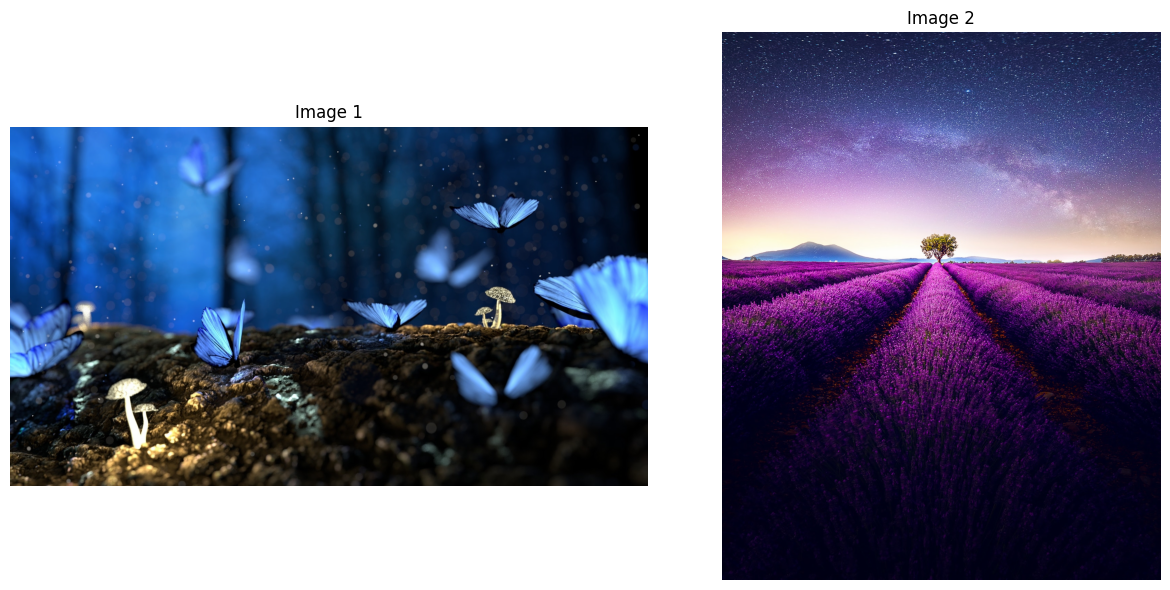

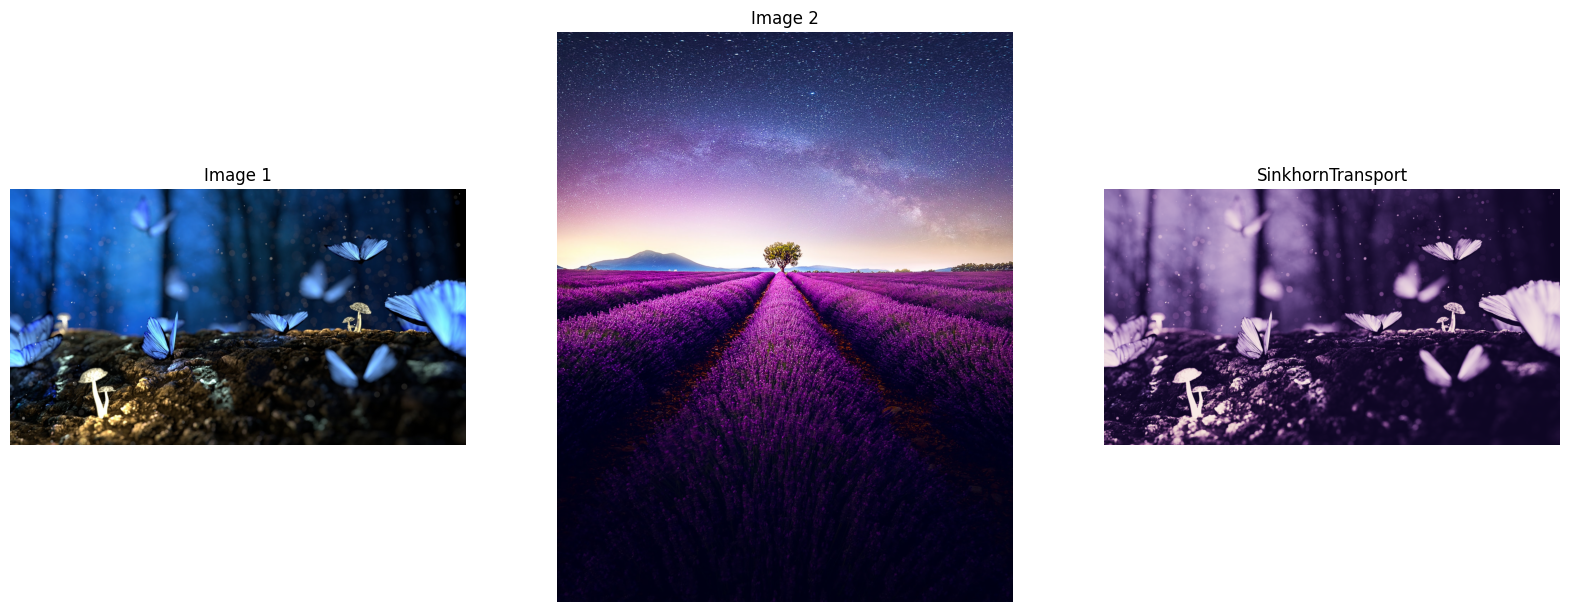

In [ ]:
imageSource = "{img}".format(img=imageSourceName)
imageTarget = "{img}".format(img=imageTargetName)
I1 = np.array(Image.open(imageSource)).astype(np.float64) / 256
I2 = np.array(Image.open(imageTarget)).astype(np.float64) / 256
X1 = imageToMatrix(I1)
X2 = imageToMatrix(I2)
r = np.random.RandomState(42)

# list of integers corresponding to the coordinates of pixels (lines of Xi)
pixelsx1 = r.randint(X1.shape[0], size=(nbpixels, ))
pixelsx2 = r.randint(X2.shape[0], size=(nbpixels, ))

Xs = X1[pixelsx1, :]  # source pixels
Xt = X2[pixelsx2, :]  # target pixels

# extract the shape
SI1 = I1.shape
row = SI1[0]
col = SI1[1]

plot_original_images(I1, I2)

Image_sinkhorn = apply_optimal_transport(X1, Xs, Xt, row, col)

plot_optimal_transport_results(I1, I2, Image_sinkhorn)

In [ ]:
# name of the source image (the one that will change color)
imageSourceName = "pokr.jpg"
# name of the target image (colors of this one will be transported onto the source image)
imageTargetName = "pinkfield.jpeg"
nbpixels = 1000  # number of pixels that will be randomly chosen

SinkhornTransport running time : 4.63110876083374


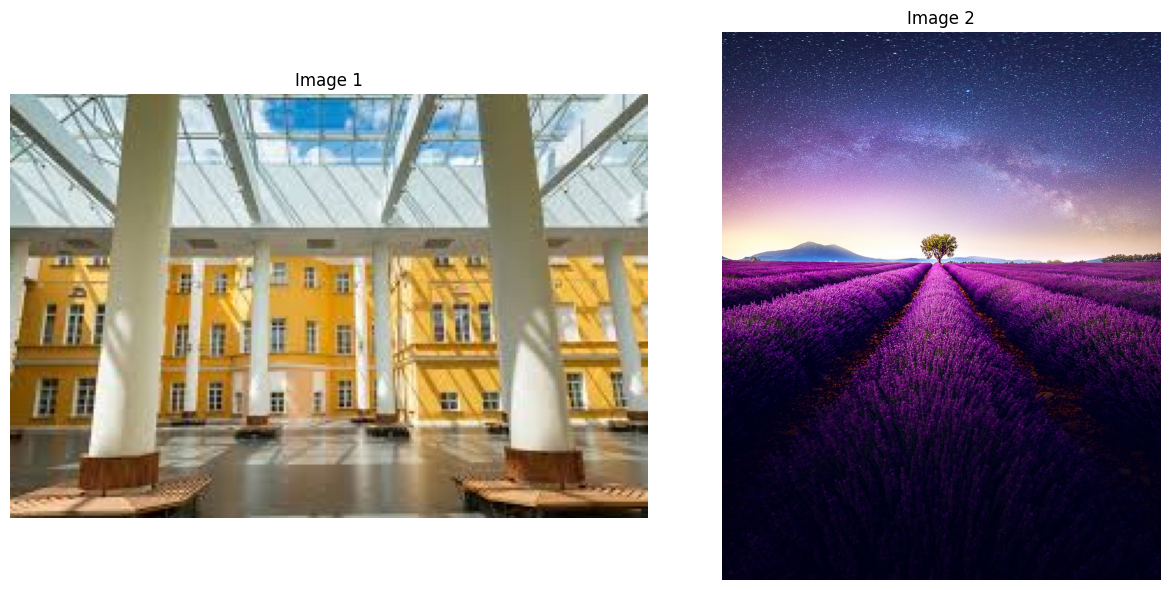

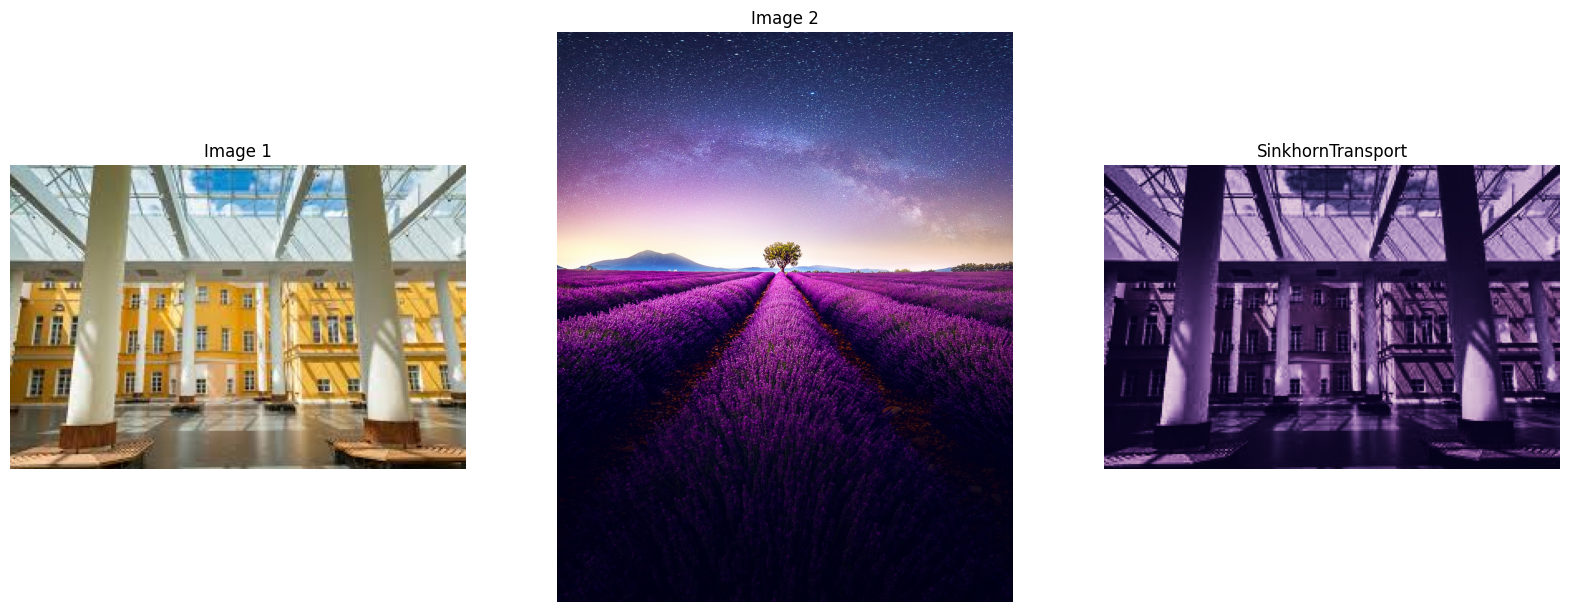

In [ ]:
imageSource = "{img}".format(img=imageSourceName)
imageTarget = "{img}".format(img=imageTargetName)
I1 = np.array(Image.open(imageSource)).astype(np.float64) / 256
I2 = np.array(Image.open(imageTarget)).astype(np.float64) / 256
X1 = imageToMatrix(I1)
X2 = imageToMatrix(I2)
r = np.random.RandomState(42)

# list of integers corresponding to the coordinates of pixels (lines of Xi)
pixelsx1 = r.randint(X1.shape[0], size=(nbpixels, ))
pixelsx2 = r.randint(X2.shape[0], size=(nbpixels, ))

Xs = X1[pixelsx1, :]  # source pixels
Xt = X2[pixelsx2, :]  # target pixels

# extract the shape
SI1 = I1.shape
row = SI1[0]
col = SI1[1]

plot_original_images(I1, I2)

Image_sinkhorn = apply_optimal_transport(X1, Xs, Xt, row, col)

plot_optimal_transport_results(I1, I2, Image_sinkhorn)